<h1>An Example of Mutation Plotting</h1>

Sometimes we would like to see the distribution of the probability caused by the mutation when we make a prediction. That is, we have to generate the mutated sequences and predict them by built model:

<b>python running.py --dataType protein --dataEncodingType dict  --dataTrainFilePaths examples/typeIIIsecretedeffectors/data/train_pos.txt examples/typeIIIsecretedeffectors/data/train_neg.txt --dataTrainLabel 1 0 --dataTestFilePaths examples/typeIIIsecretedeffectors/data/test_pos.txt examples/typeIIIsecretedeffectors/data/test_neg.txt --dataTestLabel 1 0 --modelLoadFile examples/typeIIIsecretedeffectors/model/protein_CNN_model.py --verbose 1 --outSaveFolderPath tmpOut --savePrediction 1 --saveFig 1 --batch_size 60 --epochs 20 --spcLen 300 --shuffleDataTrain 1 --modelSaveName tmpMod.json --weightSaveName tmpWeight.bin --noGPU 0 --paraSaveName parameters.txt</b>

Then generating the mutated sequences:

<b>python tool/generateShuffledSeqs.py --KMerNum 2 --outFile ../tryPython/randomSeqs.txt --generateNum 20 --withOri 1 --oriName tmp --randomly 1 --oriSeq NTINRNIYPVSGISAQDAPVQTDQLQPQGQGIRPGHNSNLIDFGLIQQANGPHSSLNTSSSRIQPTDTSTSSNRLGGNGDQLLNKLVEAIRNILNNLLSLLEGNQHQGSSPAQTQREQTPTSTQSHASPSSSSSSSPSTSSQSSPSVPSTPQGNAEKPFVVQSDHPAEKPVSLQRTSEPTSVTPPQTPPQAVERNSITPDKAPAKPEAVKPAVVNDPVLPKTSIPAAAKPDSTVTAAKHATPAARGQGADMSGMIGFAKEANTTGGNNGEVVTVNTVADLKKYMEDDKARTVKLGANLSADSKVSINFGANKTLLGTDKGNTLHNIYLASGKTASNDIFQNLNFNHDARYRENGDMQMFISSGQKYWIDHITATGTKDQNPKGLDKLLYVGGKADNVSLTNSKFQNNEYGVILGQPDDSAAAKAEYKGYPRMTIANNVFSNLDVRGPGLFRQGQFDVVNNSIDKFHLGFTATGNATILSQANYFSNGVDVSNKASNSGVLDDYGDAHFKDIGSNVSFTQKSPVTAWTPSYNRDVKTAEAARAYDLANAGAQVVK
</b>

Make a prediction:

<b>python predicting.py --paraFile tmpOut/parameters.txt --dataTestFilePaths ../tryPython/randomSeqs.txt --predictionSavePath tmpout/indPredictions.txt</b>
    
Finally generating the difference matrix:

<b>python tool/findDiff.py tmpOut/indPredictions.txt > tmpOut/diffMat.txt</b>

In this notebook, we aim at plotting the predicted probability against the original one. This function is provided as a tool '<b>mutationPlot.py</b>' at the folder '<b>tool</b>'.

<h2>Preparing</h2>

In [1]:
import os, sys
sys.path.append('../')
import  re
sys.path.append(os.path.curdir)
sys.path.append(sys.argv[0])
import numpy as np
import analysisPlot

import matplotlib as mpl
import matplotlib.pyplot as plt

Using TensorFlow backend.


<h2>Reading the difference matrix</h2>

The file is the output from <b>findDiff.py</b>, users could change it as needed.

In [13]:
fileIn = '../tmpOut/diffMat.txt'

Reading the output and translate them into a matrix. Note that the parameter <b>oriIndex</b> is to specify the index of original sequence.

In [14]:
oriIndex = 0

In [15]:

#Name1 -- Name2\tIndex1 -- Index2\tPredction1 -- Prediction2\tprobDIff
subSep = ' -- '


proteinStr = 'GAVLIPFYWSTCMNQDEKRHXBJOUZ'
dnaStr = 'AGCT'
rnaStr = 'AGCU'

mutationDict = {} # position:ori:mutation
keySet = set()
with open(fileIn) as FID:     
    rowList = []
    rowOldInd = None
    for line in FID:
        if line.startswith('#'):
            continue
        eles = line.strip().split('\t')
        name1, name2 = eles[0].split(subSep)
        index1, index2 = eles[1].split(subSep)
        index1 = int(index1)
        index2 = int(index2)
        out1, out2 = eles[2].split(subSep)
        probDiff = float(eles[3])
        if index1 == oriIndex:
            position, oriRes, mutatedRes = re.findall('(\d+)_(\w)-(\w)',name2.split('###')[1])[0]
            position = int(position)
            if not position in mutationDict:
                mutationDict[position] = {}
            if not oriRes in mutationDict[position]:
                mutationDict[position][oriRes] = {}
            mutationDict[position][oriRes][mutatedRes] = probDiff
            keySet.add(oriRes.upper())
            keySet.add(mutatedRes.upper())

if 'X' in keySet:
    keySet.remove('X')
if len(keySet) == 4:
    if 'U' in keySet:
        tempStr = rnaStr
    else:
        tempStr = dnaStr
else:
    tempStr = proteinStr

outMat = np.zeros([len(tempStr),len(list(mutationDict.keys()))])        
outStrDict = {'ori':'Seq:\t'}
for res in tempStr:
    outStrDict[res] = '%s:\t' %res
for position in np.sort(list(mutationDict.keys())):
    oriRes = list(mutationDict[position].keys())[0]
    outStrDict['ori'] += '%s\t' %oriRes
    for i,mutatedRes in enumerate(tempStr):
        if mutatedRes in mutationDict[position][oriRes]:
            outStrDict[mutatedRes] += '%.6e\t' %(mutationDict[position][oriRes][mutatedRes])
            outMat[i,position] = mutationDict[position][oriRes][mutatedRes]
        else:
            outStrDict[mutatedRes] += '0\t'
            outMat[i,position] = 0


<h2>Getting the output</h2>

Firstly, getting the text output

In [16]:
#text output 
print(outStrDict['ori'])
for res in tempStr:
    print(outStrDict[res])


Seq:	G	T	T	G	T	T	G	C	A	G	T	T	G	G	A	T	A	T	A	G	A	C	C	A	C	G	G	A	G	A	
A:	-4.900000e-05	-1.100000e-05	-3.000000e-05	1.400000e-05	5.000000e-06	-2.900000e-05	2.300000e-05	-2.000000e-05	0	-9.100000e-05	2.000000e-05	8.000000e-06	-4.700000e-05	-7.000000e-06	0	-1.190000e-04	0	-3.800000e-04	0	-4.500000e-05	0	-1.450000e-04	-3.900000e-05	0	1.300000e-05	-3.200000e-05	1.200000e-05	0	2.300000e-05	0	
G:	0	0.000000e+00	-4.700000e-05	0	-4.900000e-05	-3.150000e-04	0	6.000000e-06	2.400000e-05	0	2.000000e-05	-3.600000e-05	0	0	-2.840000e-04	-1.800000e-05	-1.740000e-04	-4.980000e-04	-2.680000e-04	0	-1.010000e-04	-7.900000e-05	3.000000e-06	2.400000e-05	2.200000e-05	0	0	-2.400000e-05	0	6.000000e-06	
C:	-4.000000e-06	7.000000e-06	7.000000e-06	-1.150000e-04	7.000000e-06	5.000000e-06	1.300000e-05	0	2.400000e-05	-4.500000e-05	-6.000000e-06	-2.200000e-05	-1.000000e-04	-2.000000e-05	-1.363000e-03	-3.245000e-03	-2.500000e-05	-1.020000e-04	-1.137000e-03	2.100000e-05	0.000000e+00	0	0	-3.100000e-05	0	-1.130000e-04	1.90000

Then the output in figure

In [17]:
minVal = np.min([-1*np.abs(outMat.min()), -1*np.abs(outMat.max())])
maxVal = np.max([np.abs(outMat.min()), np.abs(outMat.max())])

In [18]:
xTickLabels = outStrDict['ori'].split('\t')[1:-1]
yTickLabels = list(tempStr)

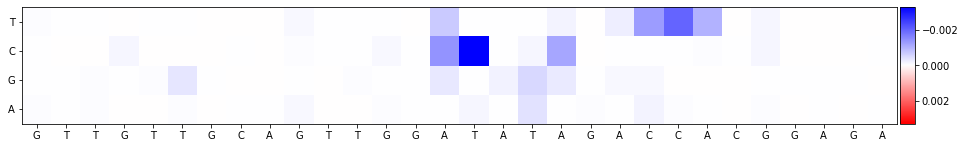

In [19]:
analysisPlot.showMatWithVal(outMat,showText=False,vmin=None,norm = mpl.colors.Normalize(vmin=minVal,vmax=maxVal),cmapName='bwr',
                            xtickLabels=xTickLabels,ytickLabels=yTickLabels,driverCaxSize=0.2)

Sometimes the length will be too long to plot in one figure, we can plot it separately.

In [20]:
windowSize = 20

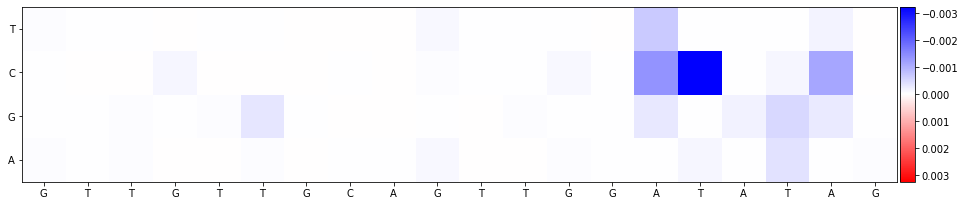

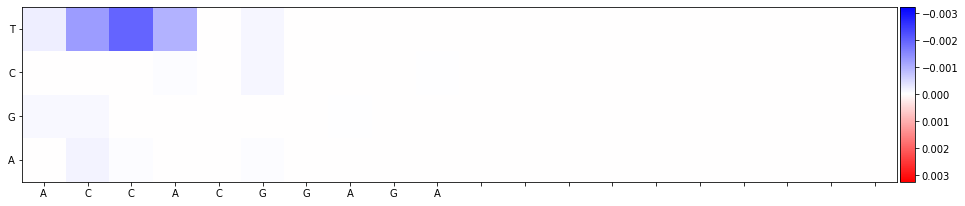

In [21]:
currPos = 0
totalLen = outMat.shape[1]
while currPos < totalLen:
    currMat = np.zeros([len(tempStr),windowSize])
    currMat[:,:np.min([windowSize, totalLen - currPos])] += outMat[:,currPos:currPos+windowSize]
    analysisPlot.showMatWithVal(currMat,showText=False,vmin=None,norm = mpl.colors.Normalize(vmin=minVal,vmax=maxVal),cmapName='bwr',
                            xtickLabels=xTickLabels[currPos:currPos+windowSize],ytickLabels=yTickLabels,driverCaxSize=0.2)
    currPos += windowSize

That's all the informations for this notebook. If you still have more issues, please fell free to connect us at ljs@swmu.edu.cn, thanks.